# This notebook has been released and executed locally because the execution of Google Collab was too long.

In [64]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0, alsologtostdout=False)
print("Tensforflow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensforflow version : 2.10.0
Num GPUs Available:  1


In [2]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully u

## Loading the BERT preprocessor and the BERT encoder from KERAS

In [1]:
import tensorflow_text as text
import tensorflow_hub as hub
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

## Loading Spam message and cleaning dataset

In [2]:
import pandas as pd
df = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv', encoding='latin', quotechar='"').fillna('')
df["v2"] = df['v2'].astype("string") + " " + df['Unnamed: 2'].astype("string") + " " + df['Unnamed: 3'].astype("string") + " " + df['Unnamed: 4'].astype("string")
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1':'Category', 'v2':'Message'}, inplace=True)
df['spam'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## Creating the tensors with training and validation datasets

In [3]:
import tensorflow as tf
full_ds = tf.data.Dataset.from_tensor_slices((df['Message'], df['spam']))

BATCH_SIZE = 64
TAKE_SIZE = int(0.7*df.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(BATCH_SIZE)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(BATCH_SIZE)

## Calculating the weigths to apply in the model training because data is unbalanced (see previous notebook)

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
weights = compute_class_weight(class_weight='balanced', classes=np.unique(df["spam"]), y=df["spam"])
weights = dict(zip(np.unique(df["spam"]), weights))
weights

{0: 0.5774093264248704, 1: 3.7295850066934406}

## Training the model on the full dataset

In [5]:
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=fr

from tensorflow.keras.layers import Input, Dropout, Dense

# Defining the layers that preprocesses the messages and encode it with BERT algorithm
text_input = Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

# creating final model from layer defeined above
model_bert = tf.keras.Model(inputs = [text_input], outputs = [outputs])
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [6]:
optimizer= tf.keras.optimizers.Adam()

# We choose to estimate a binary (0, 1) value at the end.
model_bert.compile(optimizer=optimizer,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [8]:
# Model training 
model_bert.fit(train_data,
          epochs=10, 
          validation_data=test_data,
          class_weight=weights)

Epoch 1/10
28/61 [============>.................] - ETA: 5:31 - loss: 0.5678 - binary_accuracy: 0.7455

KeyboardInterrupt: 

# !!! The model training is too long to execute. We stop it.

## We are going to downsample the dataset by balancing it with as many ham as we get spam messages.

In [9]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)
print("")

Ham Dataset Shape: (4825, 3)
Spam Dataset Shape: (747, 3)



In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 3)

In [65]:
# Concatenating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
df_balanced = pd.concat([df_spam , df_ham_downsampled])
print(df_balanced['Category'].value_counts())

spam    747
ham     747
Name: Category, dtype: int64


## Now that the dataset is balanced and the row count is lower than previously, the model should be faster.

In [13]:
df_balanced.head()

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


## Creating the tensors with balanced and undersampled dataset

In [17]:
balanced_ds = tf.data.Dataset.from_tensor_slices((df_balanced['Message'], df_balanced['spam']))

BATCH_SIZE = 64
TAKE_SIZE = int(0.7*df_balanced.shape[0])

balanced_train_data = balanced_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
balanced_train_data = balanced_train_data.batch(BATCH_SIZE)

balanced_test_data = balanced_ds.skip(TAKE_SIZE)
balanced_test_data = balanced_test_data.batch(BATCH_SIZE)

## Training the model on the balanced dataset

In [20]:
# Model training 
model_bert.fit(balanced_train_data,
          epochs=20, 
          validation_data=balanced_test_data)

Epoch 1/20
17/17 [==============================] - 223s 13s/step - loss: 0.2821 - binary_accuracy: 0.9091 - val_loss: 0.7235 - val_binary_accuracy: 0.6169
Epoch 2/20
17/17 [==============================] - 222s 13s/step - loss: 0.2724 - binary_accuracy: 0.9148 - val_loss: 0.5097 - val_binary_accuracy: 0.7684
Epoch 3/20
17/17 [==============================] - 242s 14s/step - loss: 0.2713 - binary_accuracy: 0.9158 - val_loss: 0.5577 - val_binary_accuracy: 0.7416
Epoch 4/20
17/17 [==============================] - 239s 14s/step - loss: 0.2625 - binary_accuracy: 0.9234 - val_loss: 0.6671 - val_binary_accuracy: 0.6526
Epoch 5/20
17/17 [==============================] - 242s 14s/step - loss: 0.2589 - binary_accuracy: 0.9129 - val_loss: 0.5821 - val_binary_accuracy: 0.7238
Epoch 6/20
17/17 [==============================] - 238s 14s/step - loss: 0.2493 - binary_accuracy: 0.9234 - val_loss: 0.5355 - val_binary_accuracy: 0.7528
Epoch 7/20
17/17 [==============================] - 244s 15s/ste

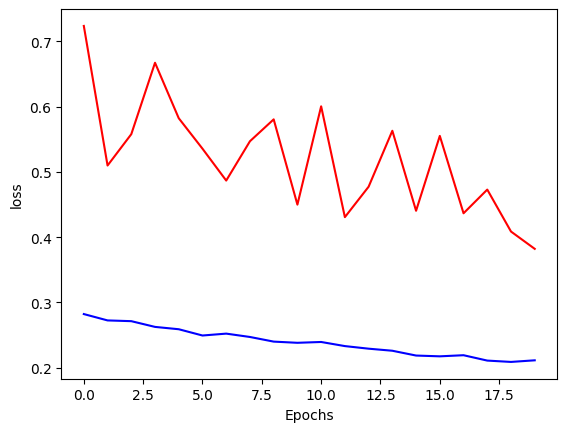

In [21]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model_bert.history.history["loss"], color="b")
plt.plot(model_bert.history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

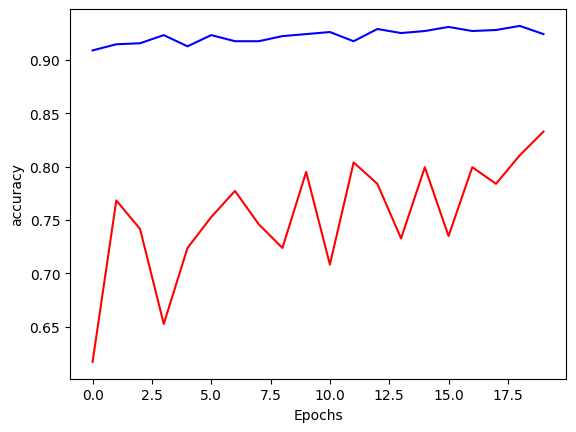

In [22]:
# Visualization of accuracy training 
plt.plot(model_bert.history.history["binary_accuracy"], color="b")
plt.plot(model_bert.history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

# The model is quite very good and keeps on converging with very good figures if we keep on training on epochs.

In [26]:
# Let's save the model with 20 epochs
model_bert.save('./SPAM_BERT_MODEL_20_epochs.HDF5')

INFO:tensorflow:Assets written to: ./SPAM_BERT_MODEL_20_epochs.HDF5\assets


INFO:tensorflow:Assets written to: ./SPAM_BERT_MODEL_20_epochs.HDF5\assets


## Let's try to train the model again with another 20 epochs and check the figures afterwards

In [30]:
from keras.models import load_model
model_bert = load_model('./SPAM_BERT_MODEL_20_epochs.HDF5')

In [31]:
# Model training 
model_bert.fit(balanced_train_data,
          epochs=20, 
          validation_data=balanced_test_data)

Epoch 1/20
17/17 [==============================] - 279s 16s/step - loss: 0.2054 - binary_accuracy: 0.9311 - val_loss: 0.4481 - val_binary_accuracy: 0.7951
Epoch 2/20
17/17 [==============================] - 264s 16s/step - loss: 0.1970 - binary_accuracy: 0.9407 - val_loss: 0.4216 - val_binary_accuracy: 0.8085
Epoch 3/20
17/17 [==============================] - 260s 16s/step - loss: 0.1948 - binary_accuracy: 0.9378 - val_loss: 0.4372 - val_binary_accuracy: 0.7973
Epoch 4/20
17/17 [==============================] - 260s 16s/step - loss: 0.1879 - binary_accuracy: 0.9407 - val_loss: 0.5197 - val_binary_accuracy: 0.7461
Epoch 5/20
17/17 [==============================] - 261s 16s/step - loss: 0.1919 - binary_accuracy: 0.9359 - val_loss: 0.3941 - val_binary_accuracy: 0.8151
Epoch 6/20
17/17 [==============================] - 261s 16s/step - loss: 0.1907 - binary_accuracy: 0.9435 - val_loss: 0.4220 - val_binary_accuracy: 0.8085
Epoch 7/20
17/17 [==============================] - 262s 16s/ste

In [32]:
# Let's save the model with 20+20 epochs
model_bert.save('./SPAM_BERT_MODEL_40_epochs.HDF5')

INFO:tensorflow:Assets written to: ./SPAM_BERT_MODEL_40_epochs.HDF5\assets


INFO:tensorflow:Assets written to: ./SPAM_BERT_MODEL_40_epochs.HDF5\assets


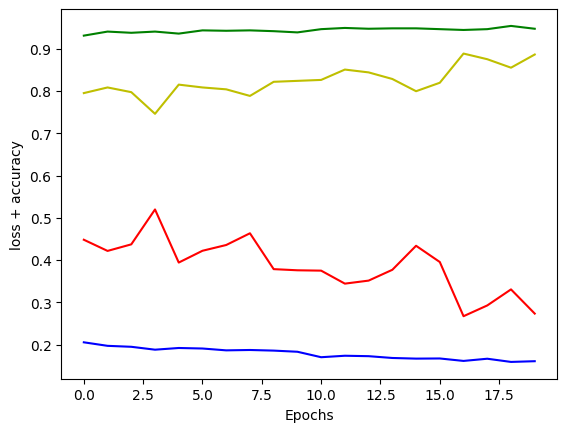

In [33]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model_bert.history.history["loss"], color="b")
plt.plot(model_bert.history.history["val_loss"], color="r")
plt.plot(model_bert.history.history["binary_accuracy"], color="g")
plt.plot(model_bert.history.history["val_binary_accuracy"], color="y")
plt.ylabel("loss + accuracy")
plt.xlabel("Epochs")
plt.show()

## Results are still very good, keep on converging.

## Let's try with another 20 epochs.

In [34]:
# Model training 
model_bert.fit(balanced_train_data,
          epochs=20, 
          validation_data=balanced_test_data)

Epoch 1/20
17/17 [==============================] - 260s 16s/step - loss: 0.1578 - binary_accuracy: 0.9550 - val_loss: 0.4280 - val_binary_accuracy: 0.7996
Epoch 2/20
17/17 [==============================] - 258s 15s/step - loss: 0.1627 - binary_accuracy: 0.9502 - val_loss: 0.2845 - val_binary_accuracy: 0.8820
Epoch 3/20
17/17 [==============================] - 259s 15s/step - loss: 0.1600 - binary_accuracy: 0.9464 - val_loss: 0.2657 - val_binary_accuracy: 0.8886
Epoch 4/20
17/17 [==============================] - 258s 15s/step - loss: 0.1567 - binary_accuracy: 0.9474 - val_loss: 0.3319 - val_binary_accuracy: 0.8508
Epoch 5/20
17/17 [==============================] - 258s 15s/step - loss: 0.1533 - binary_accuracy: 0.9502 - val_loss: 0.3937 - val_binary_accuracy: 0.8151
Epoch 6/20
17/17 [==============================] - 257s 15s/step - loss: 0.1613 - binary_accuracy: 0.9426 - val_loss: 0.2760 - val_binary_accuracy: 0.8842
Epoch 7/20
17/17 [==============================] - 257s 15s/ste

In [45]:
# Let's save the model with 20+20+20 epochs
model_bert.save('./SPAM_BERT_MODEL_60_epochs.HDF5')

INFO:tensorflow:Assets written to: ./SPAM_BERT_MODEL_60_epochs.HDF5\assets


INFO:tensorflow:Assets written to: ./SPAM_BERT_MODEL_60_epochs.HDF5\assets


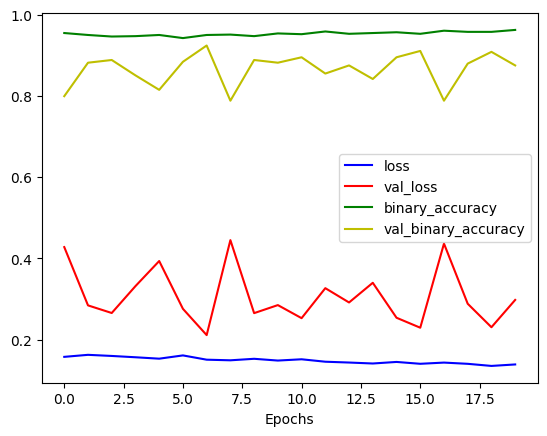

In [46]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model_bert.history.history["loss"], color="b", label = "loss")
plt.plot(model_bert.history.history["val_loss"], color="r", label = "val_loss")
plt.plot(model_bert.history.history["binary_accuracy"], color="g", label = "binary_accuracy")
plt.plot(model_bert.history.history["val_binary_accuracy"], color="y", label = "val_binary_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.show()

## From 40 to 60 epochs, results are not improving. Therefore it seems that 40 epochs are enough.

## Let's try to test it on a sample of the full Dataset

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(df['Message'], df['spam'], stratify = df['spam'])

In [48]:
X_test.shape

(1393,)

In [49]:
X_test

1150       (That said can you text him one more time?)   
2210    Just wanted to say holy shit you guys weren't ...
4747    The beauty of life is in next second.. which h...
3579    Have a lovely night and when you wake up to se...
3657    R u here yet? I'm wearing blue shirt n black p...
                              ...                        
2544    She is our sister.. She belongs 2 our family.....
4141    Infact happy new year. How are you where are y...
4055    Ha ha nan yalrigu heltini..Iyo kothi chikku, u...
5171                      Oh k. . I will come tomorrow   
355     Thank You for calling.Forgot to say Happy Onam...
Name: Message, Length: 1393, dtype: string

In [50]:
y_test.shape

(1393,)

In [51]:
y_test.value_counts()

0    1206
1     187
Name: spam, dtype: int64

In [53]:
model_bert.evaluate(X_test,y_test)
# getting y_pred by predicting over X_text and flattening it
y_pred=(model_bert.predict(X_test) > 0.5).astype("int32")
# requires to be in one-dimensional array , for easy manipulation
y_pred = y_pred.flatten()

44/44 [==============================] - 272s 6s/step


Text(50.722222222222214, 0.5, 'Actual')

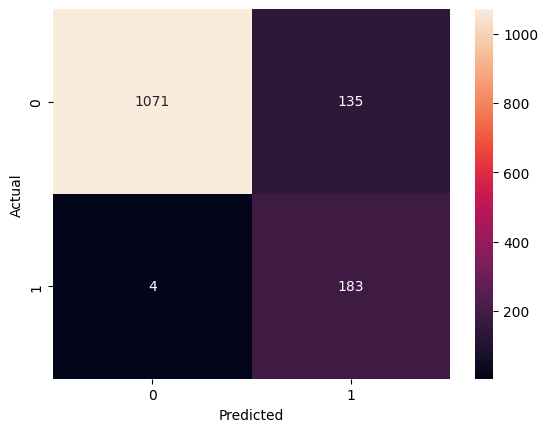

In [54]:
# importing confusion maxtrix
from sklearn.metrics import confusion_matrix, classification_report
# creating confusion matrix 
cm = confusion_matrix(y_test,y_pred)
import seaborn as sns
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [62]:
all_test = y_test.shape[0]
spam_test_counts = y_test.value_counts()[1]
spam_good_results = cm[1][1]
ham_good_results = cm[0][0]
good_results = ham_good_results + spam_good_results
print("Overall good results are", round(good_results/all_test*100, 2), "%.")
print("Spam detection result is good as", round(spam_good_results/spam_test_counts*100, 2), '%.') 

Overall good results are 90.02 %.
Spam detection result is good as 97.86 %.


## Results are very good with BERT DL model for Spam detection !!! :-)